In [1]:
import pandas as pd
import datetime
import mlflow
import pickle
from mlflow.tracking import MlflowClient

In [2]:
from training_class import TrainingPipeline

<b> Previous knowledge & considerations: </b>
- num_bed and num_bath have 12 and 7 zero values.
- condition does not have zero values
- When the renovation date is 0 is understood that the house doesn't have a renovation
- The main machine learning modeling logic is in the file training_class.py
- Model registry is performed using mlflow

In [3]:
df = pd.read_csv(".././data/house_sales.csv")

# Feature engineering

In [4]:
# Setting the 0 records to the lower value in the fields
df.loc[(df["num_bed"] == 0), "num_bed"] = 1
df.loc[(df["num_bath"] == 0), "num_bath"] = 0.5
# Computing total size in neighbor house
df["avg_total_size_neighbor"] = df["avg_size_neighbor_houses"]+df["avg_size_neighbor_lot"]
# Computing total size in the house
df["total_size"] = df["size_house"]+df["size_lot"]
# Ratio between the size and number of bedrooms
df["size_over_bed"] = df["total_size"]/df["num_bed"]
# Ratio between the size and the number of bathrooms
df["size_over_bath"] = df["total_size"]/df["num_bath"]
# Ratio between the number of floors and the number of bedrooms
df["numfloors_over_bed"] = df["num_floors"]/df["num_bed"]
# Ratio between the number of floors and the number of bathrooms
df["numfloors_over_bath"] = df["num_floors"]/df["num_bath"]
# Computing the house age in years
df["house_age"] = int(datetime.date.today().strftime("%Y")) - df["year_built"]
# Ratio between the house age and the condition
df["age_over_condition"] = df["house_age"]/df["condition"]
# Flag indicator if the house had a renovation
df["had_renovation"] = df["renovation_date"].apply(lambda x: 1 if x != 0 else 0)

# Training algorithm

In [5]:
# Setting the feature names and the model name
features_name =  list(df.columns)
features_name.remove("price")
MODEL_NAME = "House_Price_prediction"

In [6]:
# Get the experiment ID using the experiment name
client = MlflowClient()
try:
    EXPERIMENT_ID = client.get_experiment_by_name(MODEL_NAME).experiment_id
except:
    EXPERIMENT_ID = mlflow.create_experiment(MODEL_NAME)
experiment_mlflow = mlflow.get_experiment(EXPERIMENT_ID)
EXPERIMENT_ID

'2'

## Decision trees

Model training using decision trees

1. Splitting data in train - test sets: test size = 20.0 %
-------------------- Finished train - test split stage
2. Starting feature selection using a generic model
------- Standarizing data with mean 0 std of 1
------- Training model for feature selection
------- Compute feature importance
------- Features selecteds are: ['size_house', 'latitude', 'longitude', 'avg_size_neighbor_houses', 'is_waterfront', 'age_over_condition', 'num_bath', 'size_basement', 'zip']
-------------------- Finished feature selection stage
3. Grid search for hyperparameter tunning
------- hypermarameter grid search using default grid search dictionary
------- hypermarameter grid search with cv 4 partitions and scaling the inputs
------- Running the grid search fit
Fitting 4 folds for each of 198 candidates, totalling 792 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.


------- the hypermarameter selected are: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10}
-------------------- Finished hyperparameter tunning stage
4. Training final model
------- Scaling training data
-------------------- Finished model training
5. Generation model signature
-------------------- Finished model signature stage
Starting model evaluation
mae in training is 76251.16611433841
mae in testing is 90673.87588522841
mape in training is 0.1455581835839061
mape in testing is 0.17117156360237806


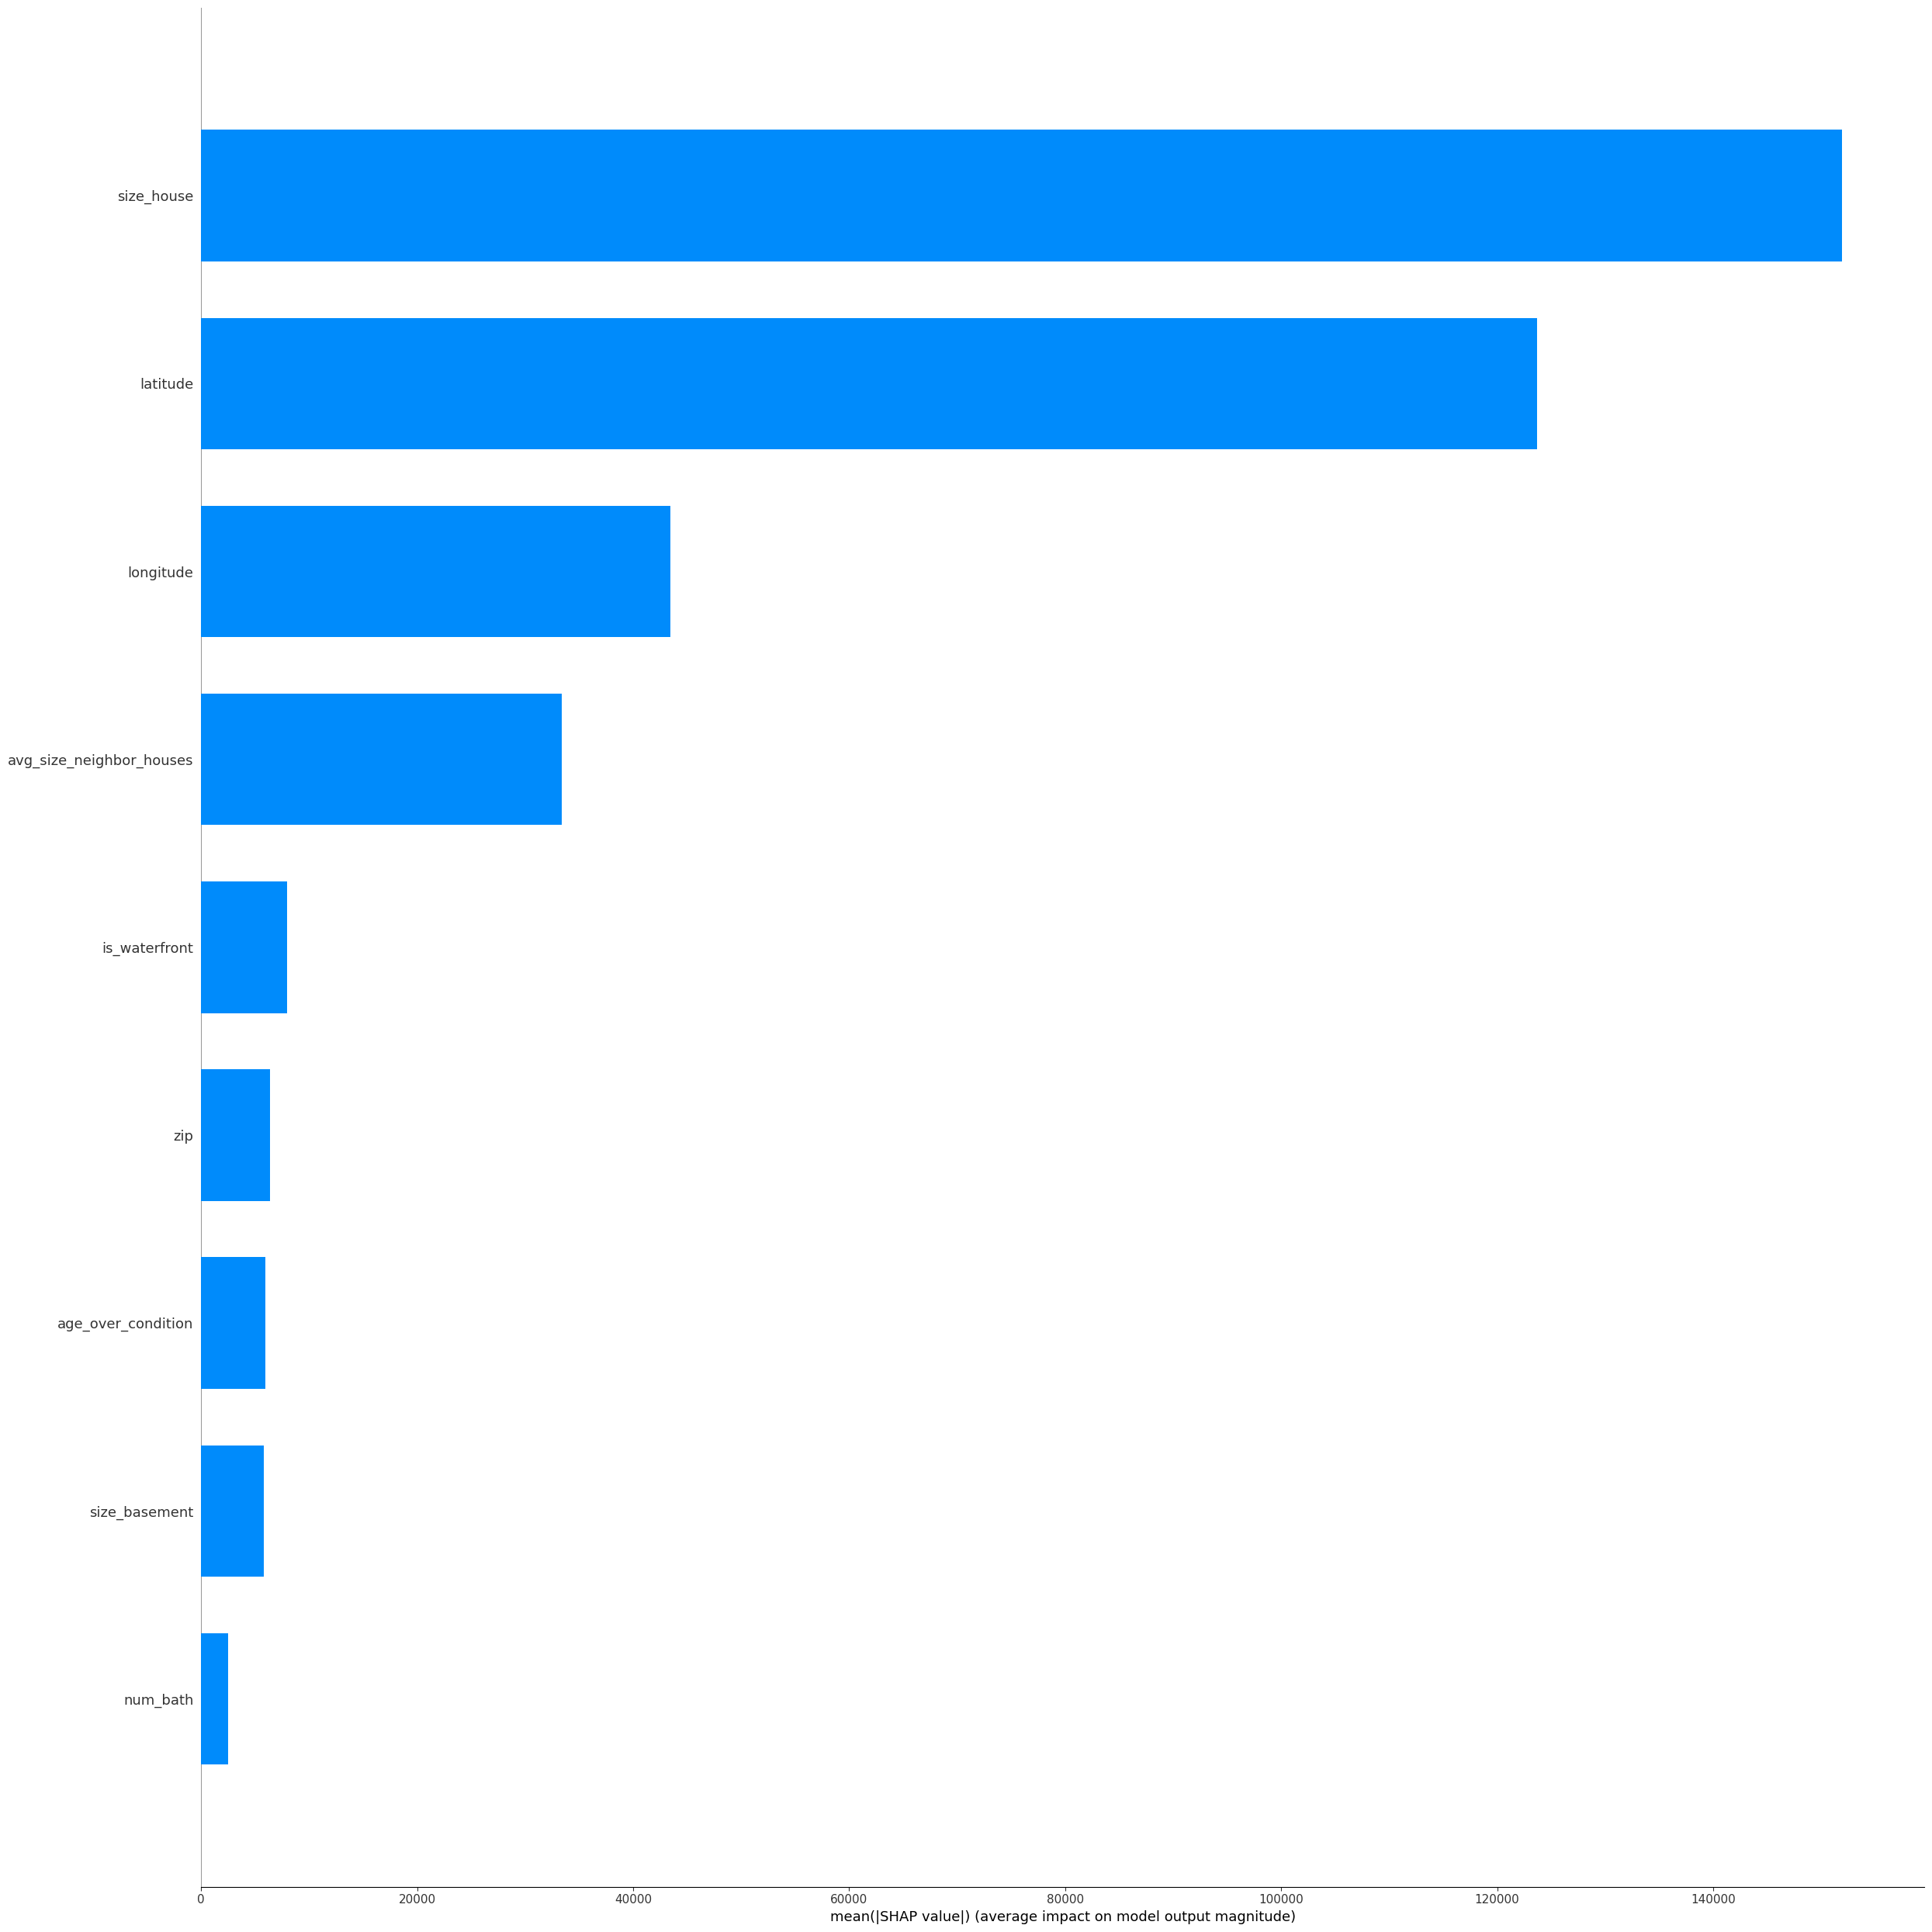

In [7]:
# Object from training_class.py with the training logic
PricePrediction = TrainingPipeline()
# Name of the run
EXPERIMENT_NAME = 'tree_price_pred'
# Relative path where the model is saved.
MODEL_PATH = 'models/trees/trees_price_pred.pkl'
# Starting mlflow run
with mlflow.start_run(run_name= EXPERIMENT_NAME, experiment_id = EXPERIMENT_ID):
    # Configuration training parameters.
    train_param = {"scale": True,
                "test_size": 0.20,
                "features" :features_name,
                "target": ["price"],
                "feature_selection": True,
                "hypotesis_model": "trees",
                "hyperparam": {}}
    # Fit the model, perform all the required steps to generate a random trees model.
    PricePrediction.fit(df, train_param)
    # Compute the mae and mape in the training and validation set.
    PricePrediction.Model_metrics()
    # Compute the shap values
    fig1 = PricePrediction.shap_explain_plot(PricePrediction.X_test)
    # Log model
    mlflow.pyfunc.log_model(EXPERIMENT_NAME, python_model = PricePrediction, signature=PricePrediction.signature)
    # Log metrics
    mlflow.log_metric('mae_train', PricePrediction.mae_score_train)
    mlflow.log_metric('mae_test', PricePrediction.mae_score_test)
    mlflow.log_metric('mape_train', PricePrediction.mape_score_train)
    mlflow.log_metric('mape_test', PricePrediction.mape_score_test)
    # Log model parameters
    mlflow.log_params(PricePrediction.hyperparam)
    # storing pickle model file
    outfile = open(MODEL_PATH,'wb')
    pickle.dump({'training_params':train_param,'model':PricePrediction},outfile)
    outfile.close()
    mlflow.log_artifact(MODEL_PATH)

## Boosting models

Main logic for the gradientboost model training

1. Splitting data in train - test sets: test size = 20.0 %
-------------------- Finished train - test split stage
2. Starting feature selection using a generic model
------- Standarizing data with mean 0 std of 1
------- Training model for feature selection
------- Compute feature importance
------- Features selecteds are: ['size_house', 'latitude', 'avg_size_neighbor_houses', 'longitude', 'is_waterfront', 'zip', 'num_bath']
-------------------- Finished feature selection stage
3. Grid search for hyperparameter tunning
------- hypermarameter grid search using default grid search dictionary
------- hypermarameter grid search with cv 4 partitions and scaling the inputs
------- Running the grid search fit
Fitting 4 folds for each of 81 candidates, totalling 324 fits
------- the hypermarameter selected are: {'learning_rate': 0.03, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.7}
-------------------- Finished hyperparameter tunning stage

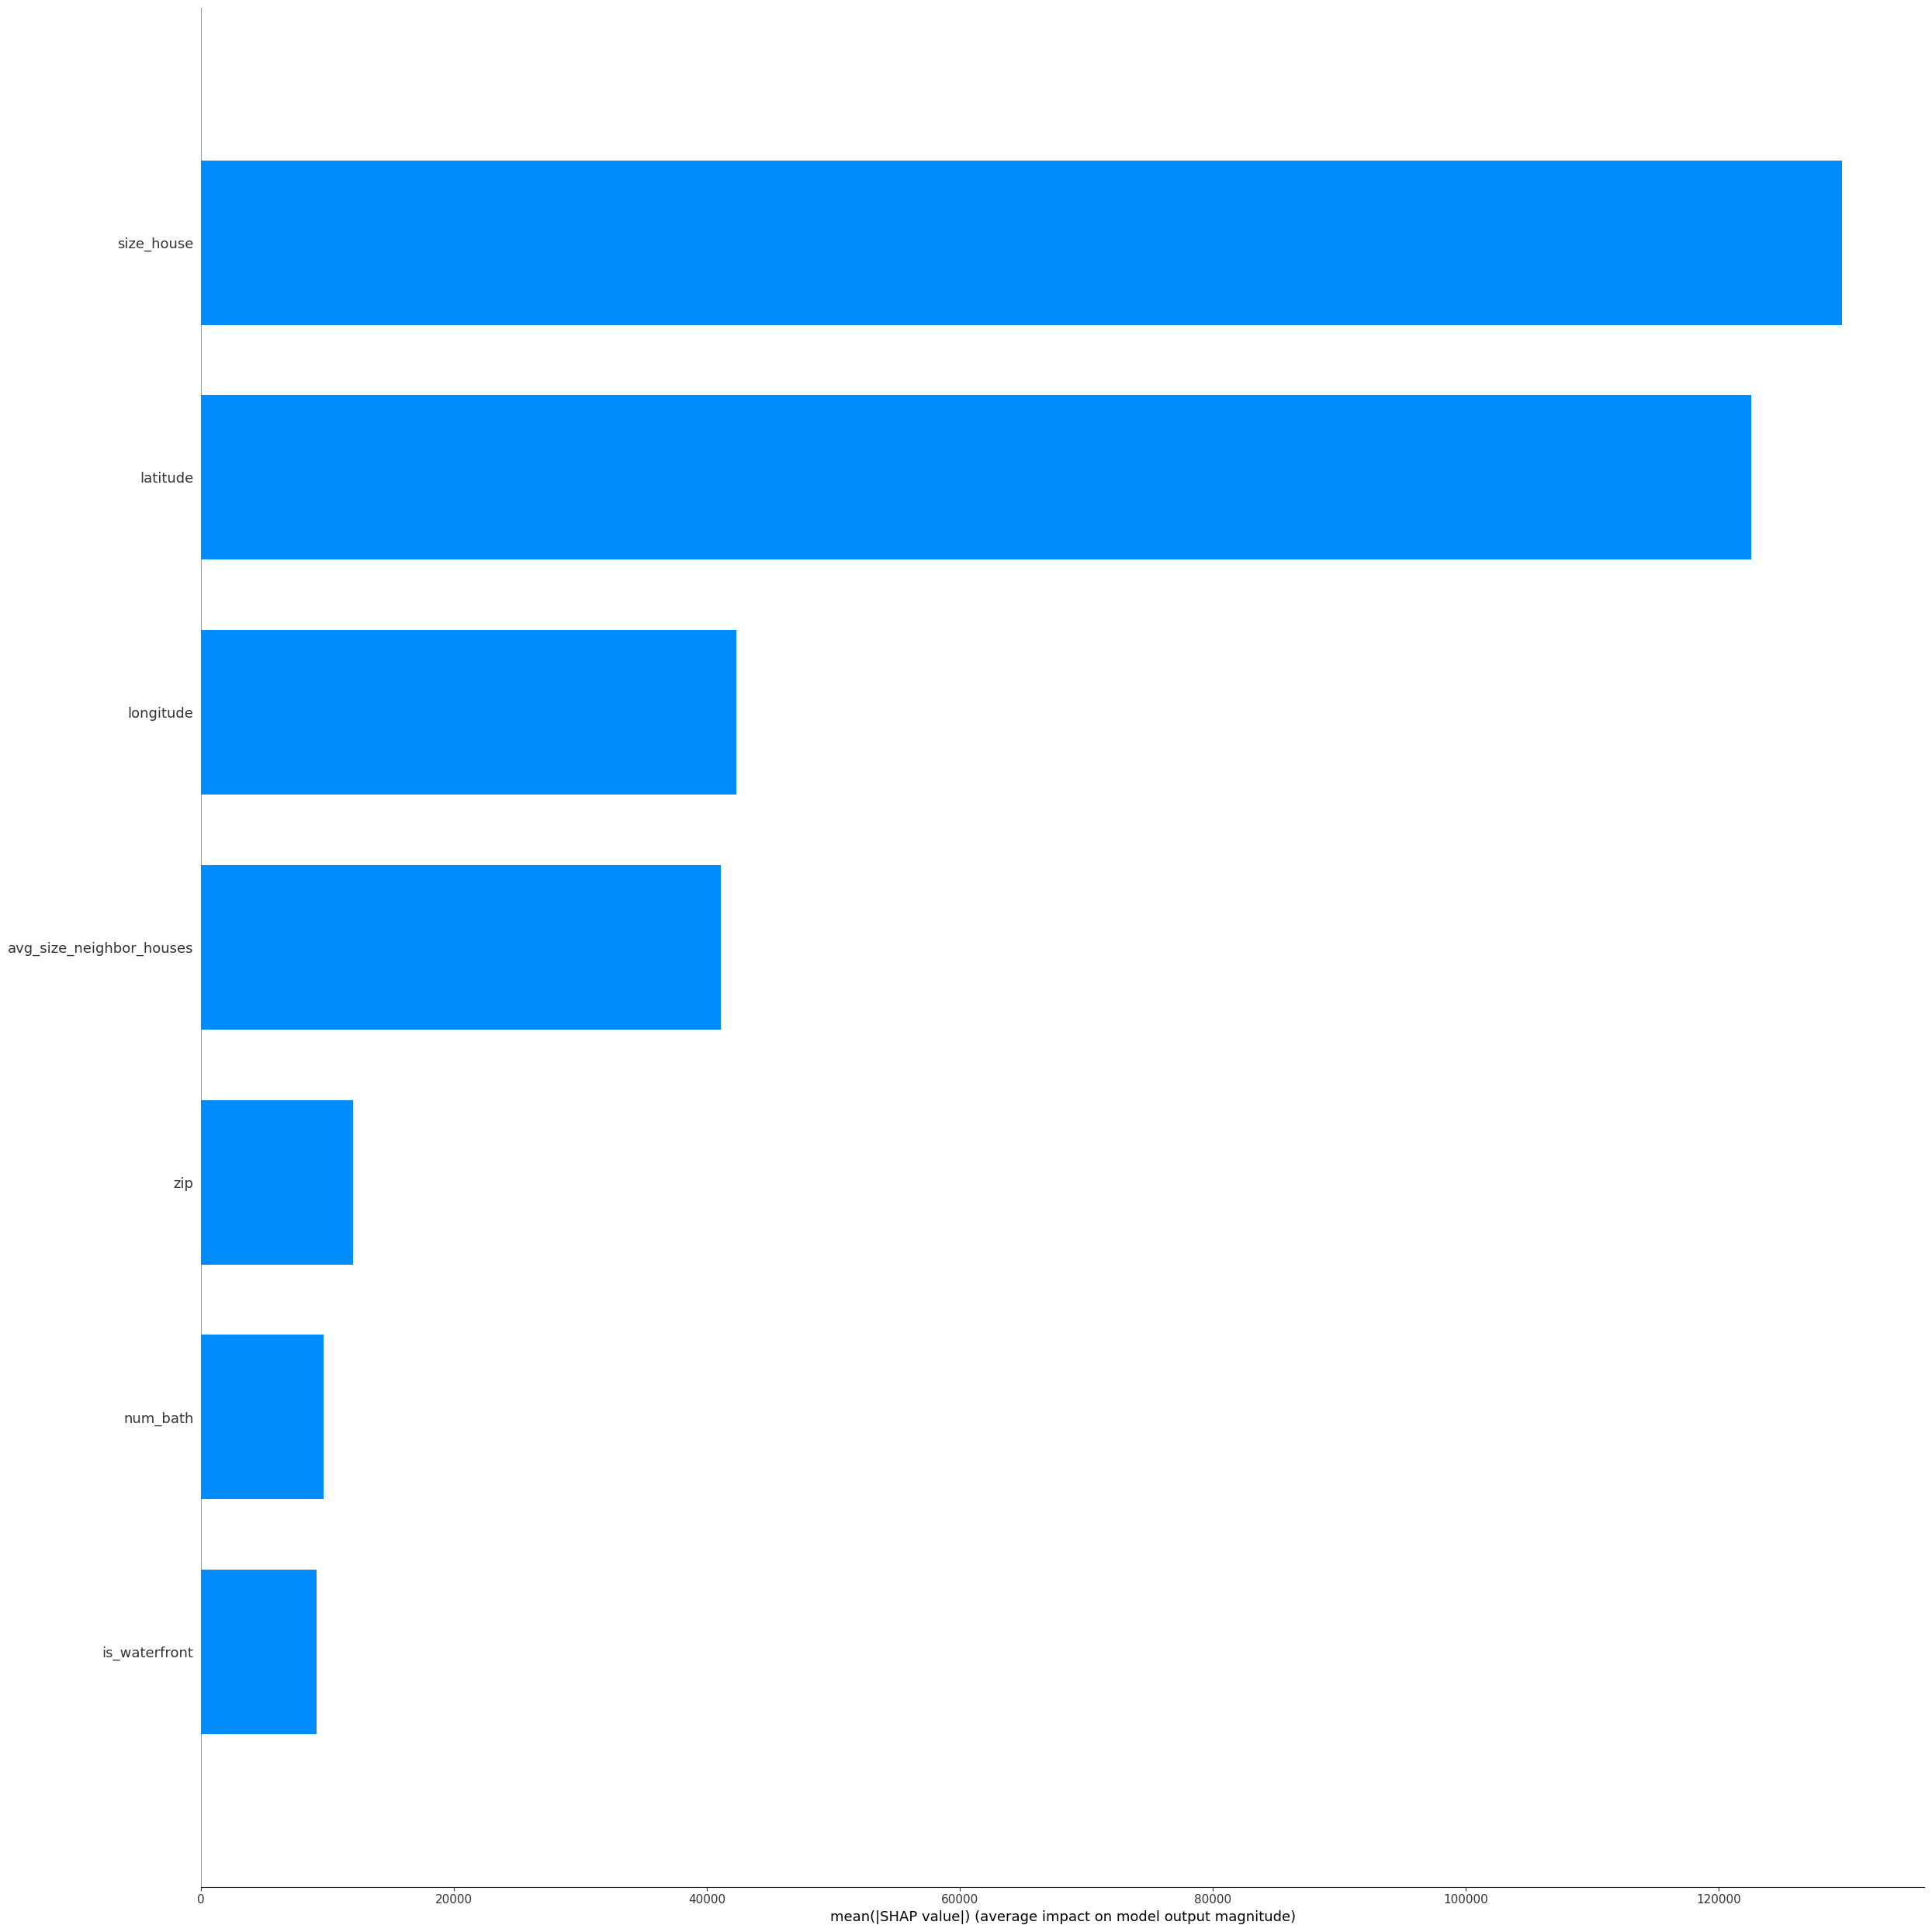

In [8]:
PricePrediction = TrainingPipeline()
EXPERIMENT_NAME = 'gradientboost_price_pred'
MODEL_PATH = 'models/gradientboost/trees_price_pred.pkl'
with mlflow.start_run(run_name= EXPERIMENT_NAME, experiment_id = EXPERIMENT_ID):
    train_param = {"scale": True,
                "test_size": 0.20,
                "features" :features_name,
                "target": ["price"],
                "feature_selection": True,
                "hypotesis_model": "gradientboost",
                "hyperparam": {}}

    PricePrediction.fit(df, train_param)
    PricePrediction.Model_metrics()
    fig1 = PricePrediction.shap_explain_plot(PricePrediction.X_test)
    # Log model
    mlflow.pyfunc.log_model(EXPERIMENT_NAME, python_model = PricePrediction, signature=PricePrediction.signature)
    # Log metrics
    mlflow.log_metric('mae_train', PricePrediction.mae_score_train)
    mlflow.log_metric('mae_test', PricePrediction.mae_score_test)
    mlflow.log_metric('mape_train', PricePrediction.mape_score_train)
    mlflow.log_metric('mape_test', PricePrediction.mape_score_test)
    # Log model parameters
    mlflow.log_params(PricePrediction.hyperparam)
    # storing pickle model file
    outfile = open(MODEL_PATH,'wb')
    pickle.dump({'training_params':train_param,'model':PricePrediction},outfile)
    outfile.close()
    mlflow.log_artifact(MODEL_PATH)

# Selecting best experiment

In [9]:
result_list = []
ALL_RUNS_ID = mlflow.search_runs(EXPERIMENT_ID).sort_values("metrics.mape_test")
best_run_id = ALL_RUNS_ID.loc[0,'run_id']
ALL_RUNS_ID[ALL_RUNS_ID["run_id"] == best_run_id]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mae_test,metrics.mape_test,metrics.mape_train,metrics.mae_train,...,params.min_samples_leaf,params.n_estimators,params.subsample,params.max_features,tags.mlflow.source.git.commit,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user
0,30c114b6825447998c7a3bb11bbf79c2,2,FINISHED,file:///D:/proyectos/Rappi/rappi_ds_test/model...,2022-10-05 12:24:17.701000+00:00,2022-10-05 12:34:42.527000+00:00,75099.952501,0.142196,0.121701,58827.964569,...,4,500,0.7,None,fd437883b5c440db38906d3099507dc1787fc6bd,d:\proyectos\Rappi\rappi_ds_test\.venv\lib\sit...,"[{""run_id"": ""30c114b6825447998c7a3bb11bbf79c2""...",LOCAL,gradientboost_price_pred,CALA ARIAS


# Conclusions

- Best model is the boosting model with a mape in the testing set of 0.142
- The most important features that explain the outputs are the latitude, size_house, avg_size_neighbor_house, longitude, zip. Which implies that the house size and location cause the major impact in the price.
- These results are highly related with the results in the EDA's.